In [1]:
# More experiments with the data generation
from astropy.io import ascii
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Convenience function for plotting the images
stddev = 0.017359
def stretch(img):
    return np.arcsinh(np.clip(img, a_min=0.0, a_max=10.0) / stddev)

In [3]:
cutouts = h5py.File('/srv/scratch/z5214005/lrg_cutouts_resized.hdf')

lrgs = ascii.read('/srv/scratch/z5214005/lrgs_sampled.tbl')
keys = lrgs['new_ids']
zs = lrgs['z']

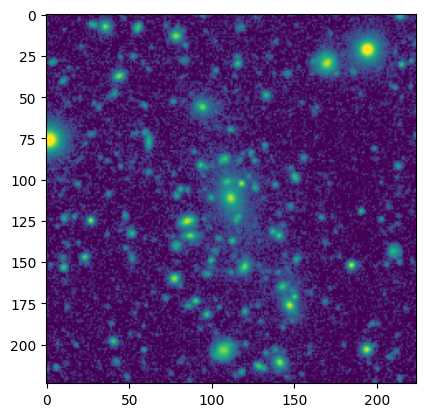

In [4]:
cutout_num = 1427

key = keys[cutout_num]

cutout = cutouts[key]['HDU0']['DATA']

plt.imshow(stretch(cutout))
plt.show()

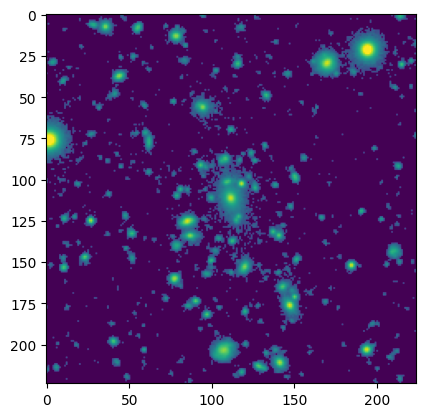

In [5]:
z = zs[cutout_num]

# Generate the surface brightness threshold
sb_threshold = 25 + 10 * np.log10(1 + z)
threshold = 10**(-0.4*(sb_threshold - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168)))

# Display the cutout with everything below the threshold removed
plt.imshow(stretch(cutout) * (cutout > threshold))
plt.show()

18.027756377319946


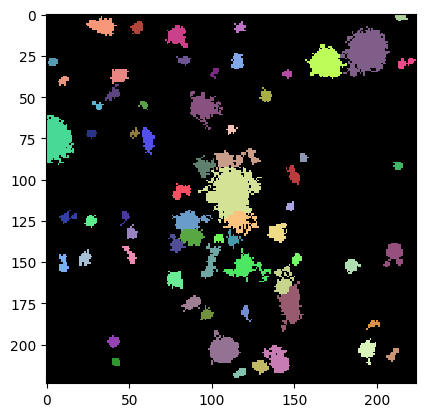

In [6]:
from photutils.segmentation import SourceFinder
import scipy

finder = SourceFinder(npixels=20, progress_bar=False, nlevels=8)

# Figure out what to use as r_eff
bright_parts = (cutout > threshold)
segm = finder(cutout, threshold)
labels = segm.data

plt.imshow(labels, cmap=segm.cmap, interpolation='nearest')

centre = (cutout.shape[0] // 2, cutout.shape[1] // 2)
central_blob = bright_parts * (labels == labels[centre[0], centre[1]])

edges = scipy.spatial.ConvexHull(np.argwhere(central_blob)) # Convex hull of central blob

distances = scipy.spatial.distance.cdist([centre], np.argwhere(central_blob)[edges.vertices])[0] # Distances to edges of shape
r_eff = np.random.choice(distances) # Vague estimate of size of central blob
print(r_eff)

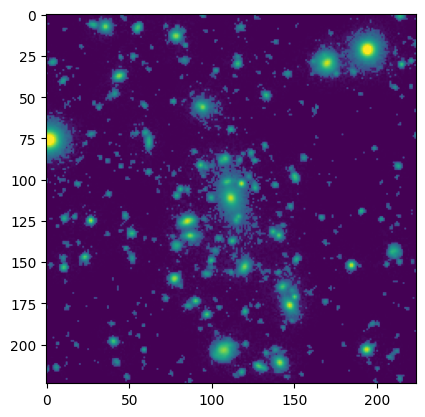

In [7]:
from astropy.convolution import Gaussian2DKernel, convolve
from skimage.morphology import binary_opening

# Expand the masks of non central galaxies
non_central_galaxies = bright_parts * ~central_blob 
kernel = Gaussian2DKernel(7) # Large ish kernel
non_central_blurred = binary_opening(non_central_galaxies) # Erase tiny bright parts (get rid of specks in ICL area)
non_central_blurred = convolve(non_central_blurred, kernel) # Expand masks
# Put just the blurred edges into the original mask
non_central_blurred = np.where(non_central_galaxies | central_blob, non_central_galaxies, non_central_blurred)

final_bright_parts = non_central_blurred + central_blob

plt.imshow(stretch(cutout) * final_bright_parts)
plt.show()

0.04073290458317828 0.20806680934576344 0.9069389426054547


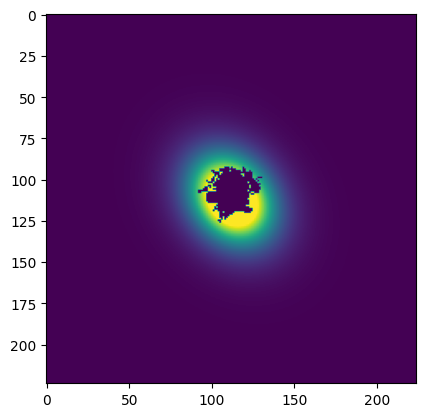

In [8]:
from astropy.modeling.functional_models import Sersic2D

# Generate some random parameters for the profile
amplitude = threshold
n = 1 # exponential profile
ellip = np.random.uniform(low=0, high=0.5)
theta = np.random.uniform(low=0, high=2*np.pi)

# Generate the model
model = Sersic2D(amplitude=amplitude, r_eff=r_eff, n=n, x_0=centre[1], y_0=centre[0], ellip=ellip, theta=theta)
x,y = np.meshgrid(np.arange(cutout.shape[1]), np.arange(cutout.shape[0]))

icl_img = np.clip(model(x,y), a_min=None, a_max=threshold)
icl_img = np.where(central_blob, 0, icl_img)

print(amplitude, ellip, theta)
plt.imshow(stretch(icl_img))
plt.show()

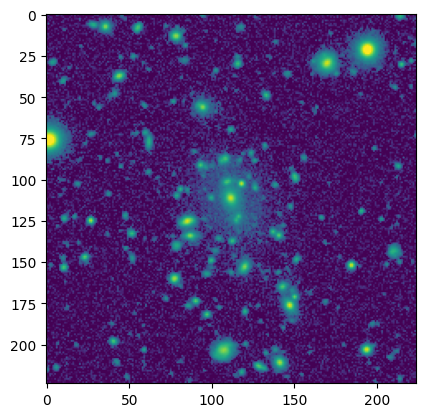

In [9]:
# Add to the bright parts
img_no_noise = (cutout * final_bright_parts) + icl_img #np.clip(model(x,y), a_min=None, a_max=threshold)

# Generate some noise
std = np.std(cutout * ~bright_parts) # Standard deviation of the background (+icl)
noise = np.random.normal(loc=0, scale=std, size=cutout.shape)

# Add to final image
img = img_no_noise + noise
# img = cutout + icl_img
img = img.astype('<f4')
plt.imshow(stretch(img))
plt.show()

In [10]:
from astropy.stats import sigma_clipped_stats

# Calculate the new artificial ICL fraction
sb_limit = 28 + 10 * np.log10(1+z) # Calculate the sb limit
limit = 10**(-0.4*(sb_limit - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168))) # Convert to counts
icl = np.sum(icl_img[icl_img > limit])

# total = np.sum(img_no_noise) # Total brightness (without considering noise)
_, med, _ = sigma_clipped_stats(cutout)
total = np.sum(((np.array(cutout) - med) * central_blob) + icl_img)

print(icl/total)

0.2404402116490131


In [21]:
# Now measure this new image
from measure_sb_cut.scripts import measure_icl
from skimage.morphology import binary_closing
from astropy.cosmology import FlatLambdaCDM
from photutils.segmentation import deblend_sources, SegmentationImage

cosmo = FlatLambdaCDM(H0=68.4, Om0=0.301)

def calc_icl_frac(cutout, num):
    plt.figure(figsize=(8,8))
    plt.subplot(221)
    plt.imshow(stretch(cutout))
    # Background estimate
    bkg = measure_icl.background_estimate(cutout, zs[num], cosmo)
    bkg_subtracted = cutout - bkg

    plt.subplot(222)
    plt.imshow(stretch(bkg_subtracted))
    # Segment the image
    cold_labels = measure_icl.create_cold_labels(cutout, np.zeros(cutout.shape, dtype=bool))
    cold_labels = deblend_sources(cutout, SegmentationImage(cold_labels), npixels=20, progress_bar=False).data
    # Create cold mask
    cold_mask = measure_icl.enlarge_mask(cold_labels, sigma=0.5)

    # Unsharp mask the image for hot mask creation
    kernel = Gaussian2DKernel(5) 
    conv_img = convolve(np.array(cutout), kernel)
    unsharp = np.array(cutout) - conv_img

    # Create hot mask
    hot_mask_bkg = measure_icl.background_estimate(unsharp, zs[num], cosmo=cosmo)
    hot_labels = measure_icl.create_hot_labels(unsharp, cold_mask, background=hot_mask_bkg)
    hot_mask = measure_icl.enlarge_mask(hot_labels, sigma=0.33)

    # Create the "member mask"
    mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
    bcg_label = cold_labels[mid[0], mid[1]]
    member_mask = (cold_labels == bcg_label) | (cold_labels == 0)
    non_member_mask = ~member_mask
    non_member_mask = measure_icl.enlarge_mask(non_member_mask, sigma=0.66)
    non_member_mask = non_member_mask + hot_mask
    member_mask = ~non_member_mask
    
    plt.imshow(member_mask)

    # Make the circular mask
    # Get the BCG's label
    mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
    bcg_label = cold_labels[mid[0], mid[1]]

    # Coordinates of points that are part of the BCG
    pts = np.array(np.argwhere(cold_labels == bcg_label))

    # Find points that are furthest apart
    candidates = pts[scipy.spatial.ConvexHull(pts).vertices]
    dist_mat = scipy.spatial.distance_matrix(candidates, candidates)
    i, j = np.unravel_index(dist_mat.argmax(), dist_mat.shape)
    pt1 = candidates[i]
    pt2 = candidates[j]

    size = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

    # Make sure that the radius is >=100kpc
    # radius = np.max((size, cosmo.arcsec_per_kpc_proper(zs[num]).value * 100 * 1/0.168))
    radius = size

    # Generate the mask
    centre = (cutout.shape[1] // 2, cutout.shape[0] // 2)
    Y, X = np.ogrid[:cutout.shape[0], :cutout.shape[1]]
    dist_from_centre = np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)
    circ_mask = dist_from_centre <= radius

    plt.subplot(223)
    plt.imshow(stretch(cutout * member_mask * circ_mask))

    # Calculate surface brightness limit
    _, _, stddev = sigma_clipped_stats(bkg_subtracted)
    sb_lim = -2.5 * np.log10(3 * stddev/(0.168 * 10)) + 2.5 * np.log10(63095734448.0194)

    # Convert image from counts to surface brightness
    np.seterr(invalid='ignore', divide='ignore')
    sb_img = measure_icl.counts2sb(bkg_subtracted, 0)

    # Mask values below surface brightness limit
    sb_img[sb_img >= sb_lim] = np.nan

    # Mask above the surface brightness threshold
    threshold = 25 + 10 * np.log10(1 + zs[num])
    mask = sb_img > threshold

    # Close the mask
    mask = binary_closing(mask)

    # Convert the SB image back to counts
    counts_img = measure_icl.sb2counts(sb_img) 

    # Close the nans to try and get rid of the noise that contributes to the ICL?
    nans = np.isnan(counts_img)
    nans = binary_closing(nans)
    not_nans = ~nans

    # Display the final image
    masked_img = counts_img * member_mask * circ_mask * not_nans
    plt.subplot(224)
    cmap = plt.cm.get_cmap('viridis')
    cmap.set_bad(cmap(0))
    plt.imshow(stretch(masked_img) * mask, cmap=cmap, interpolation='none')

    print(f'ICL = {np.nansum(masked_img * mask)}')
    print(f'Total = {np.nansum(masked_img)}')

    return np.nansum(masked_img * mask) / np.nansum(masked_img)

/tmp/ipykernel_2937588/2306407435.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


ICL = 26.597106363143407
Total = 266.54603248069947
0.09978428909861675
Injected ICL = 61.029566489071506
Total light = 253.82429199555233


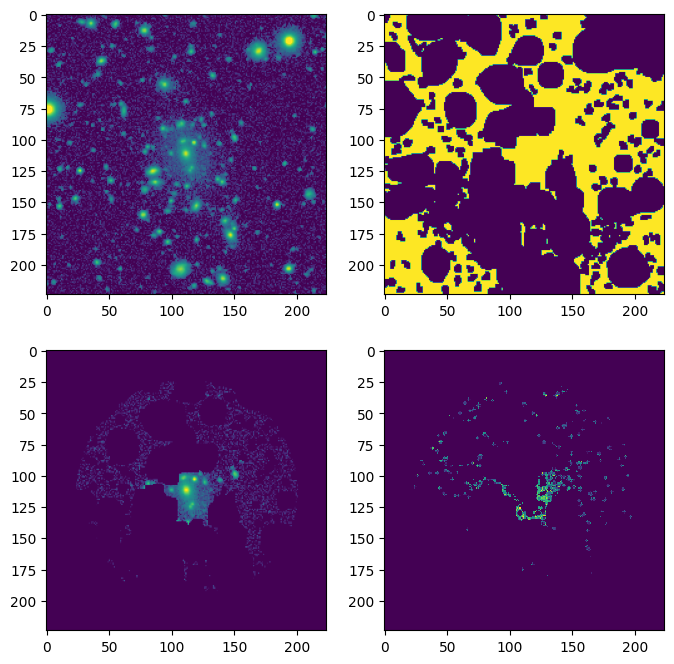

In [22]:
print(calc_icl_frac(img, cutout_num))

print(f'Injected ICL = {icl}')
print(f'Total light = {total}')

In [13]:
# How much noise is there on average in the deep images? 